In [1]:
# Crypto plot

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('seaborn')
%matplotlib inline

In [3]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Coinbase"
f = requests.get(url)
ipdata = f.json()
pd.DataFrame(ipdata['Data']).head(5)

,time,close,high,low,open,volumefrom,volumeto
0,1574553600,6908.64,7344.00,6865.00,7329.29,10399.12,7.368713e+07
1,1574640000,7127.01,7379.99,6526.00,6908.64,26339.93,1.830673e+08
2,1574726400,7162.67,7340.59,7021.84,7127.01,11809.08,8.439124e+07
3,1574812800,7523.72,7678.76,6850.00,7162.67,18089.43,1.326784e+08
4,1574899200,7432.41,7660.82,7370.62,7523.72,8602.08,6.480446e+07


In [4]:
def get_data(date):
    """query API for 2000 days historical price data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(
        date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [5]:
def get_df(from_date, to_date):
    date = to_date
    holder = []
    # while earliest date returned is later than the earliest data requested, keep querying API # and adding results to list
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
        # join together all api queries from list
        df = pd.concat(holder, axis=0)
        # remove data points from before from_date
        df = df[df['time'] > from_date]
        # convert to timestamp
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('time', inplace=True)
        return df

In [6]:
df_sept = get_df(1567296000, 1569801600)
df_oct = get_df(1569888000, 1572480000)
df_nov = get_df(1572566400, 1575294994)
df_dec = get_df(1575158400, 1575477457)

df_sept_a = df_sept[['close']]
df_oct_a = df_oct[['close']]
df_nov_a = df_nov[['close']]
df_dec_a = df_dec[['close']]

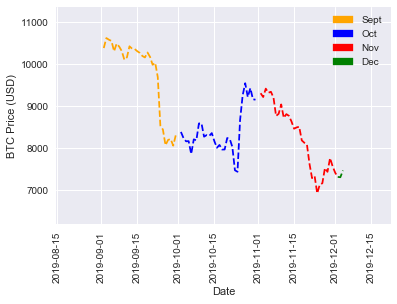

In [7]:
plt.plot(df_sept_a, linestyle='dashed', label='September', color='orange')
plt.plot(df_oct_a, linestyle='dashed', label='October', color='blue')
plt.plot(df_nov_a, linestyle='dashed', label='November', color='red')
plt.plot(df_dec_a, linestyle='dashed', label='December', color='green')
orange_patch = mpatches.Patch(color='orange', label='Sept')
blue_patch = mpatches.Patch(color='blue', label='Oct')
red_patch = mpatches.Patch(color='red', label='Nov')
green_patch = mpatches.Patch(color='green', label='Dec')
plt.legend(handles=[orange_patch, blue_patch, red_patch, green_patch])
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation='vertical')
plt.margins(0.2)
plt.show()